# Session 2: Inside Qwen 2.5
## Visualizing the Internals of a Modern LLM

In this notebook, we use the **Qwen 2.5 (0.5B)** model. This is a state-of-the-art "Tiny" model that outperforms the older GPT-2 significantly.

**Hybrid Setup:**
* We use **Ollama** for Generation and Embeddings (Speed).
* We use **HuggingFace Transformers** to extract Attention Maps (Internals).

In [16]:
# 1. Setup
#!pip3 install torch --index-url https://download.pytorch.org/whl/cpu

import torch
import ollama
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM
from sklearn.decomposition import PCA

# Config for plots
%matplotlib inline
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

MODEL_NAME = "Qwen/Qwen3-0.6B" # HuggingFace ID
OLLAMA_EMBEDDINGS = "all-minilm"
OLLAMA_MODEL = "qwen3:0.6b"   # Ollama ID

## Part 1: Tokenization (The Alien Language)
LLMs do not see words; they see "Tokens". Qwen uses a different tokenizer than GPT-2, allowing it to be more efficient with code and multi-lingual text.

Original Text: 'Artificial Intelligence is fascinating yet complex.'
Token IDs: [9286, 16488, 21392, 374, 26291, 3602, 6351, 13]


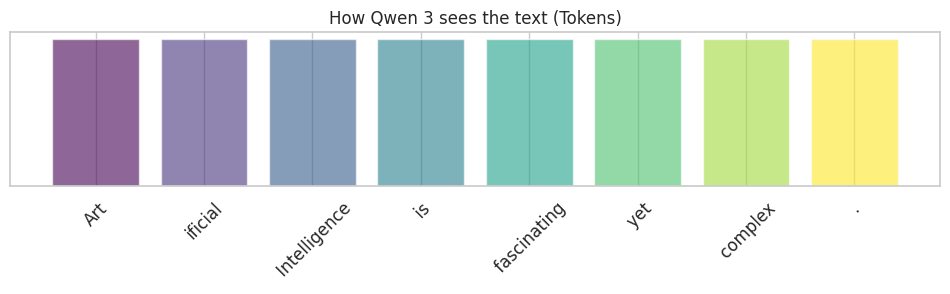

In [17]:
# Load Tokenizer from HuggingFace (Ollama hides this step)
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, trust_remote_code=True)

text = "Artificial Intelligence is fascinating yet complex."
tokens = tokenizer.tokenize(text)
ids = tokenizer.encode(text)

print(f"Original Text: '{text}'")
print(f"Token IDs: {ids}")

# Visualization of Tokens
plt.figure(figsize=(12, 2))
colors = plt.cm.viridis(np.linspace(0, 1, len(tokens)))
plt.bar(range(len(tokens)), [1]*len(tokens), color=colors, alpha=0.6)

# Qwen tokenizer uses bytes, so we decode for display
decoded_tokens = [tokenizer.decode([i]) for i in ids]
plt.xticks(range(len(tokens)), decoded_tokens, rotation=45, fontsize=12)
plt.yticks([])
plt.title("How Qwen 3 sees the text (Tokens)")
plt.show()

## Part 2: Embeddings via Ollama
Here we use the running **Ollama server** to extract the vector embeddings. These vectors represent the "meaning" of the words in high-dimensional space.

Fetching embeddings from Ollama... (Ensure 'ollama serve' is running)
Shape of Data: (4, 384)

✅ Data looks valid. Variance is: 0.0026024307284754013
First 5 values of first vector: [-0.05965864  0.05043382 -0.06958082  0.07965212 -0.04672924]


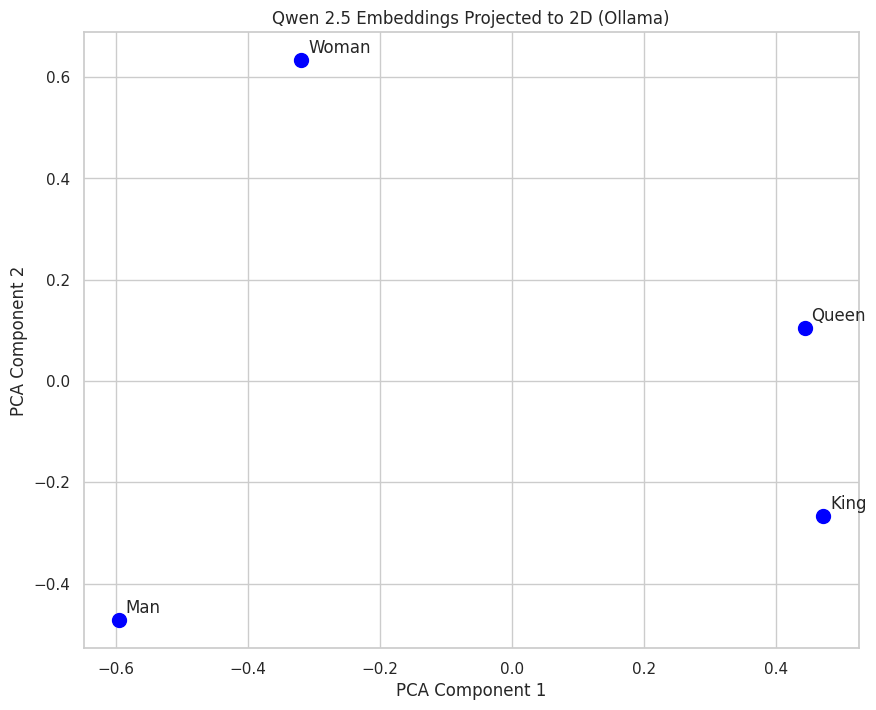

In [18]:
# Words to compare
words = ["King", "Queen", "Man", "Woman"]
vectors = []

print("Fetching embeddings from Ollama... (Ensure 'ollama serve' is running)")
for w in words:
    # We use the Ollama Python library here
    resp = ollama.embeddings(model=OLLAMA_EMBEDDINGS, prompt=w, options={"num_gpu": 0})
    vectors.append(resp['embedding'])

vectors = np.array(vectors)

if len(vectors) == 0:
    print("ERROR: No vectors were fetched.")
else:
    # Convert to numpy if not already
    vec_np = np.array(vectors)

    print(f"Shape of Data: {vec_np.shape}")

    # 2. Check for NaNs (Not a Number)
    if np.isnan(vec_np).any():
        print("\n❌ CRITICAL ISSUE: The embeddings contain NaNs!")
        print("This often happens with ROCm/AMD when the model quantization is incompatible.")
        print("Try using a different model or forcing CPU mode.")

    # 3. Check for Zeros
    elif np.all(vec_np == 0):
        print("\n❌ CRITICAL ISSUE: All embeddings are pure Zeros.")
        print("The model is running but failing to compute the math.")

    # 4. Check variance (Are all vectors identical?)
    elif np.var(vec_np) == 0:
        print("\n❌ ISSUE: Variance is 0. All word vectors are identical.")

    else:
        print("\n✅ Data looks valid. Variance is:", np.var(vec_np))
        print("First 5 values of first vector:", vec_np[0][:5])

# Reduce to 2D using PCA
pca = PCA(n_components=2)
vectors_2d = pca.fit_transform(vectors)

# Visualization
plt.figure(figsize=(10, 8))
plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1], c='blue', s=100)

for i, word in enumerate(words):
    plt.annotate(word, (vectors_2d[i, 0], vectors_2d[i, 1]), xytext=(5, 5), textcoords='offset points', fontsize=12)

plt.title(f"Qwen 2.5 Embeddings Projected to 2D (Ollama)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

## Part 3: Attention Map (The Brain)
To see the **Attention Weights** (how words look at each other), we must load the model weights directly. Ollama does not expose this internal matrix.

We calculate attention for: *"The animal didn't cross the street because it was too tired"*

Loading Model Weights from HuggingFace (This may take a moment)...


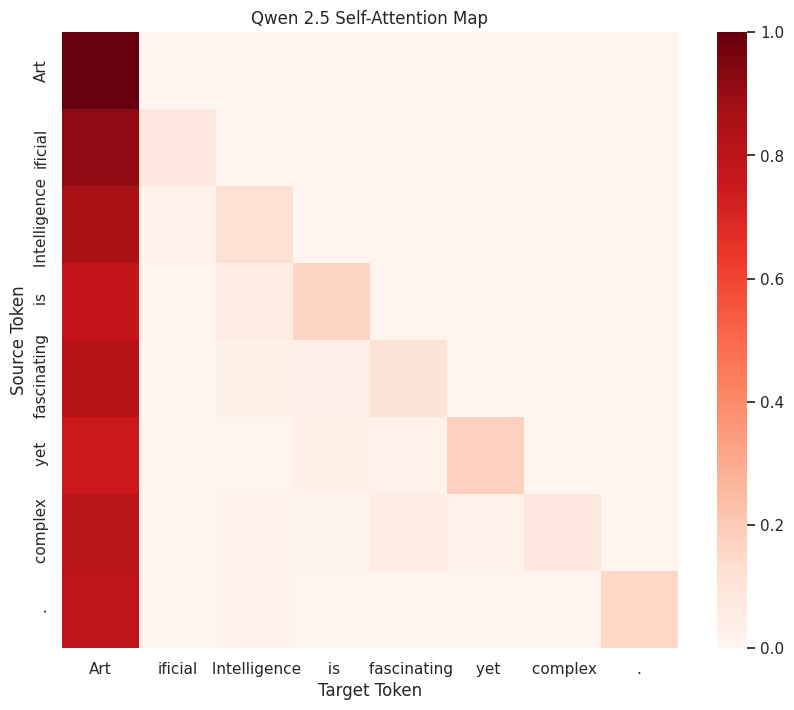

In [19]:
# Load Model Weights (Tiny ~1GB download)
print("Loading Model Weights from HuggingFace (This may take a moment)...")
hf_model = AutoModelForCausalLM.from_pretrained(MODEL_NAME, output_attentions=True, trust_remote_code=True)

text_attn = "Artificial Intelligence is fascinating yet complex."
inputs = tokenizer(text_attn, return_tensors='pt')

with torch.no_grad():
    outputs = hf_model(**inputs)

# Extract Attention from the last layer
attentions = outputs.attentions[-1].detach().numpy()[0]
avg_attention = np.mean(attentions, axis=0) # Average across heads

tokens_attn = [tokenizer.decode([t]) for t in inputs['input_ids'][0]]

# Visualization
plt.figure(figsize=(10, 8))
sns.heatmap(avg_attention, xticklabels=tokens_attn, yticklabels=tokens_attn, cmap='Reds', square=True)
plt.title("Qwen 2.5 Self-Attention Map")
plt.xlabel("Target Token")
plt.ylabel("Source Token")
plt.show()

**Insight:** Look at the column/row intersection for **"is"**. 
Does Qwen associate "is" more strongly with "complex" or "fascinating"? This heatmap visualizes the model's reasoning.

## Part 4: Chat Generation via Ollama
Finally, we use the Ollama API for what it does best: fast text generation.

In [20]:
prompt = "Explain the concept of Quantum Entanglement to a 5 year old."

print(f"Asking Ollama ({OLLAMA_MODEL}): '{prompt}'\n")
print("-" * 60)

# Stream the response
stream = ollama.chat(
    model=OLLAMA_MODEL,
    messages=[{'role': 'user', 'content': prompt}],
    stream=True,
)

for chunk in stream:
    print(chunk['message']['content'], end='', flush=True)

print("\n" + "-" * 60)

Asking Ollama (qwen3:0.6b): 'Explain the concept of Quantum Entanglement to a 5 year old.'

------------------------------------------------------------
Okay, let's try to explain it to a 5-year-old. So, imagine two friends, Alice and Bob. If Alice flips her coin, Bob's ball also flips. Even if they're far apart, their states are linked. But in reality, they are separate. But in quantum mechanics, they can be connected in a way that their states are linked, even if they're far away. So, it's like a superposition of states, but the key is that their states are connected. That's the concept of quantum entanglement! 🌌✨
------------------------------------------------------------
